<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import prophet

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'])

In [25]:
train_col_of_interest = train[['date','country_code', 'location_key_x', 'new_confirmed']]
test_col_of_interest = test[['date','country_code', 'location_key_x', 'new_confirmed']]

In [26]:
# group by countries
train_col_of_interest_gp = train_col_of_interest.groupby(['country_code','date'])
test_col_of_interest_gp = test_col_of_interest.groupby(['country_code','date'])

In [27]:
train_agg = train_col_of_interest_gp.agg('sum')
train_agg.reset_index(level = 'country_code', inplace = True)
test_agg = test_col_of_interest_gp.agg('sum')
test_agg.reset_index(level = 'country_code', inplace = True)

<ipython-input-27-d0a6c7074d1a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_agg = train_col_of_interest_gp.agg('sum')
<ipython-input-27-d0a6c7074d1a>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_agg = test_col_of_interest_gp.agg('sum')


In [37]:
train_agg_us = train_agg.loc[train_agg.country_code == 'US','new_confirmed']
train_agg_us_df = pd.DataFrame(train_agg_us)
test_agg_us = test_agg.loc[test_agg.country_code == 'US','new_confirmed']
test_agg_us_df = pd.DataFrame(test_agg_us)

In [39]:
train=train_agg_us_df.iloc[:]['new_confirmed']
test=test_agg_us_df.iloc[: ]['new_confirmed']
print(train.shape, test.shape)

(719,) (258,)


In [41]:
model = prophet.Prophet().fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhxauc8d/czobcaia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhxauc8d/hx47k27z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95453', 'data', 'file=/tmp/tmpyhxauc8d/czobcaia.json', 'init=/tmp/tmpyhxauc8d/hx47k27z.json', 'output', 'file=/tmp/tmpyhxauc8d/prophet_modeluvq4rwrf/prophet_model-20231103185222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [42]:
train_pred=model.predict(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-01-13,-13626.528931,-70445.850144,61995.537848,-13626.528931,-13626.528931,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,0.0,0.0,0.0,-2754.691942
2020-01-14,-13290.680926,-80546.265933,52482.229017,-13290.680926,-13290.680926,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,0.0,0.0,0.0,-11185.738017
2020-01-15,-12954.832921,-67443.255968,65281.014146,-12954.832921,-12954.832921,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,0.0,0.0,0.0,-3832.185894
2020-01-16,-12618.984917,-75200.860996,58885.070796,-12618.984917,-12618.984917,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,0.0,0.0,0.0,-5277.799302
2020-01-17,-12283.136912,-70325.117664,64824.253559,-12283.136912,-12283.136912,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,0.0,0.0,0.0,-2234.139472


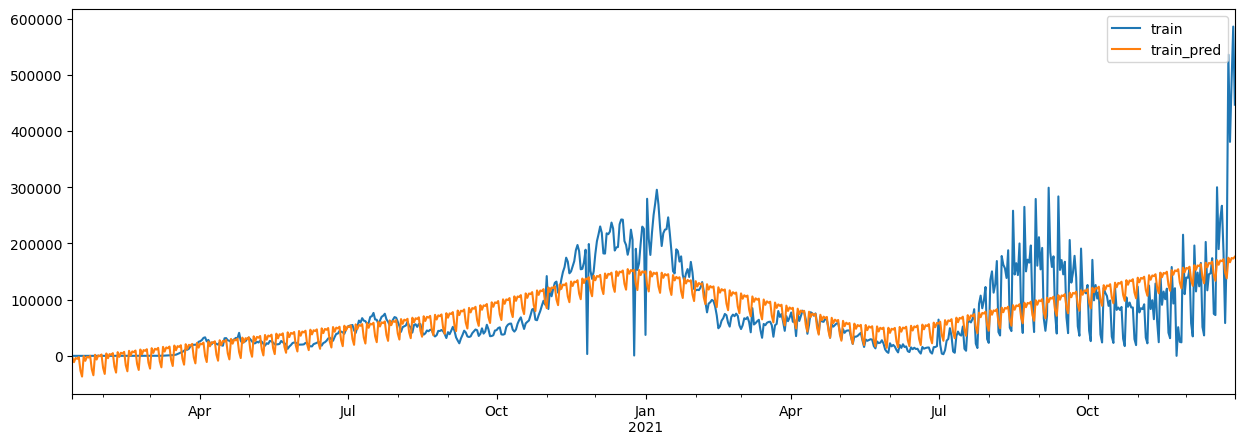

In [43]:
pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

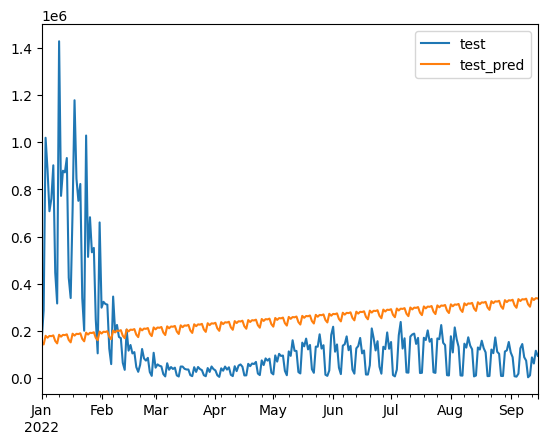

In [44]:
test_pred=model.predict(test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])